In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
from pesummary.utils.samples_dict import SamplesDict
import bilby
import sys

## Get injection data SNRs

In [2]:
base_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
                             'CE4020ET123_CoBA10_SNR_3_pop_PLP_spin_aligned_fref_5_z_MD_zmax_10_lmrd_22_365_days_corrected_td_SNR_data.h5')
#inj_data_file = os.path.join(base_dir, 'SNR_output_files_XPHM', 'BBH', 
#                             'LHI_SNR_1_pop_PLP_spin_prec_z_MD_zmax_6_lmrd_22_365_days_corrected_td_SNR_data.h5')

In [3]:
def decode_bytes_recursive(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    elif isinstance(val, np.ndarray):
        if val.dtype.kind == 'S':  # Byte string array
            return np.vectorize(lambda x: x.decode('utf-8'))(val)
        elif val.dtype.kind in {'O'}:
            return np.vectorize(decode_bytes_recursive)(val)
        else:
            return val
    elif isinstance(val, list):
        return [decode_bytes_recursive(v) for v in val]
    elif isinstance(val, dict):
        return {k: decode_bytes_recursive(v) for k, v in val.items()}
    return val

def load_h5_group(group):
    data = {}
    for key in group.keys():
        item = group[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            data[key] = load_h5_group(item)
    return data

In [4]:
# Main loader
inj_data = {}
with h5py.File(inj_data_file, 'r') as f:
    for key in f.keys():
        item = f[key]
        if isinstance(item, h5py.Dataset):
            val = item[()]
            inj_data[key] = decode_bytes_recursive(val)
        elif isinstance(item, h5py.Group):
            inj_data[key] = load_h5_group(item)

In [5]:
pd.DataFrame(inj_data['results'])

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,SNR_E3,...,spin1z,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,89.081424,57.270932,18.387193,14.800440,10.186230,...,-0.061128,0.0,0.0,0.126310,7.140745,6.850547,6.088491,13.991292,1401.516982,1.893025e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,5.955440,4.285237,11.389722,8.947595,10.628861,...,0.406850,0.0,0.0,0.114056,7.725840,5.403342,5.606829,13.129181,1051.424937,1.893026e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,26.147823,19.659339,9.576124,11.215747,9.800301,...,0.190466,0.0,0.0,0.135335,9.001862,6.051958,6.400407,15.053820,1476.593981,1.893028e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,18.312133,8.410959,11.706618,11.557690,11.564004,...,0.078424,0.0,0.0,0.051417,7.757496,3.677842,4.587108,11.435338,255.032633,1.893028e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,118.750050,48.394232,48.624391,52.568369,59.959634,...,-0.002809,0.0,0.0,0.016454,9.604591,9.163552,8.166602,18.768143,726.809460,1.893029e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31723,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,143.715625,85.026031,27.309742,17.701951,22.978051,...,-0.106414,0.0,0.0,-0.383791,11.843026,11.747124,10.268108,23.590151,740.015986,1.924564e+09
31724,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,27.652694,27.344690,33.924644,35.764627,22.748134,...,-0.011413,0.0,0.0,0.065236,24.015931,15.653630,16.802628,39.669561,2680.661719,1.924566e+09
31725,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,44.165223,30.338099,15.876198,13.373911,8.137935,...,-0.174605,0.0,0.0,-0.286785,24.025652,21.389956,19.728316,45.415608,1494.141073,1.924568e+09
31726,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,25.082589,11.767914,2.780939,4.864452,4.881824,...,0.002227,0.0,0.0,0.365035,11.909734,3.737950,5.626409,15.647684,1654.495984,1.924570e+09


### Get detected

In [6]:
def get_detected_SNRs(data_dict, ifo_threshold=5, network_threshold=12, 
                      method='network', return_detected_dict=False, 
                      snr_type='mf_from_opt'):
    if type(data_dict) == pd.core.frame.DataFrame:
        pass
    else:
        data_dict = pd.DataFrame(data_dict)
        
    if snr_type == 'opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR' in key and 'mf' not in key]
    elif snr_type == 'mf_from_opt':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf_from_opt' in key]
    elif snr_type == 'mf':
        SNR_keys = [key for key in data_dict.keys() if 'SNR_mf' in key and 'from_opt' not in key]
    else:
        raise KeyError('Please choose snr_type from "opt" or "mf"')
    print(SNR_keys)
    detected_bool_dict = {}
    detected_dict = {}
    
    for key in SNR_keys:
        if snr_type == 'opt':
            dict_key = key.split('SNR_')[-1]
        elif snr_type == 'mf_from_opt':
            dict_key = key.split('SNR_mf_from_opt_')[-1]
        elif snr_type == 'mf':
            dict_key = key.split('SNR_mf_')[-1]
        
        if "network" in key:
            threshold = network_threshold
        else:
            threshold = ifo_threshold

        detected_bool_dict[dict_key] = data_dict[key] >= threshold
        detected_dict[dict_key] = data_dict[detected_bool_dict[dict_key]]

    if method=='all':
        detected_events_df = data_dict[np.all(tuple(detected_bool_dict.values()), axis=0) & detected_bool_dict['network']]
    elif method == 'two-detector':
        detector_keys = [key for key in detected_bool_dict.keys() if key != 'network']
        detection_sum = np.sum([detected_bool_dict[key] for key in detector_keys], axis=0)
        detected_events_df = data_dict[(detection_sum >= 2) & (detected_bool_dict['network'])]
    elif method=='network':
        detected_events_df = detected_dict['network']

    if return_detected_dict:
        return(detected_events_df, detected_dict)
    else:
        return(detected_events_df)

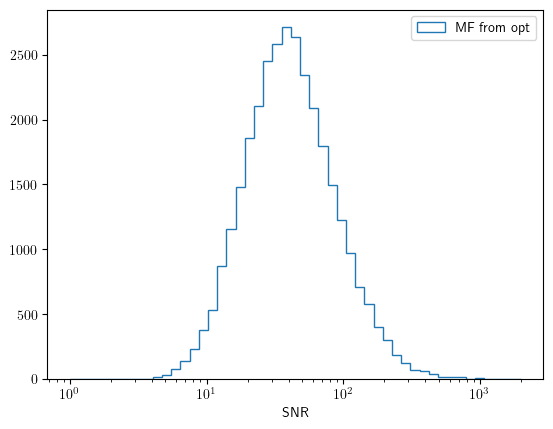

In [7]:
plt.hist(inj_data['results']['SNR_mf_from_opt_network'], bins=np.logspace(0,3.3,50), histtype=u'step', label='MF from opt');
plt.xlabel('SNR')
plt.legend()
plt.xscale('log')

In [8]:
inj_data['detected_mf_from_opt'] = get_detected_SNRs(inj_data['results'], method='two-detector', 
                                                     snr_type='mf_from_opt', network_threshold=800)

['SNR_mf_from_opt_C1', 'SNR_mf_from_opt_CE20', 'SNR_mf_from_opt_E1', 'SNR_mf_from_opt_E2', 'SNR_mf_from_opt_E3', 'SNR_mf_from_opt_network']


### Detected percentage

In [9]:
n_total = len(inj_data['results']['redshift'])
n_detected = len(inj_data['detected_mf_from_opt']['redshift'])

print('Total =', n_total)
print('detected =', n_detected, '=', round(n_detected*100/n_total, 3), '%')

Total = 31728
detected = 12 = 0.038 %


### Choose n_events from detected as injection parameters

In [10]:
n_events = len(inj_data['detected_mf_from_opt']['redshift'])
inj_data['selected_n_events'] = inj_data['detected_mf_from_opt'].iloc[:n_events].reset_index(drop=True)
inj_data['selected_n_events'].insert(5, 'SNR_ET', np.sqrt(inj_data['selected_n_events']['SNR_E1']**2 + inj_data['selected_n_events']['SNR_E2']**2 + inj_data['selected_n_events']['SNR_E3']**2))

In [11]:
len(inj_data['selected_n_events']['redshift'])

12

In [12]:
inj_data['selected_n_events']

,PSD_C1,PSD_CE20,PSD_E1,PSD_E2,PSD_E3,SNR_ET,SNR_C1,SNR_CE20,SNR_E1,SNR_E2,...,spin1z,spin2x,spin2y,spin2z,srcmass1,srcmass2,srcmchirp,srcmtotal,time_interval,trigger_time
0,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,610.677065,645.303397,279.304654,350.265698,356.727793,...,-0.071188,0.0,0.0,-0.208930,32.090738,28.724333,26.422600,60.815071,267.300640,1.893838e+09
1,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,464.503683,1101.040608,602.839680,296.654061,259.556514,...,0.185501,0.0,0.0,-0.300242,54.484866,50.114238,45.481693,104.599104,528.413543,1.897406e+09
2,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,639.627016,661.214469,360.637788,374.062897,355.173553,...,0.071207,0.0,0.0,0.152612,16.952515,13.635966,13.220274,30.588481,445.030161,1.897438e+09
3,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,1107.906903,1760.834500,1277.037024,725.446305,638.728113,...,0.075151,0.0,0.0,-0.119489,9.747148,7.380603,7.369560,17.127751,1237.323370,1.898255e+09
4,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,576.230069,699.908140,503.228814,285.201981,335.610843,...,-0.125856,0.0,0.0,-0.119446,41.679439,40.607330,35.813749,82.286769,868.150741,1.898721e+09
5,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,309.302000,817.416787,371.705246,151.392326,178.097366,...,0.058238,0.0,0.0,0.014943,51.785463,34.010147,36.374482,85.795611,756.419816,1.900703e+09
6,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,349.435574,638.394975,400.263621,207.893566,192.298387,...,0.328406,0.0,0.0,0.036007,16.478593,10.377971,11.324250,26.856565,190.819746,1.901578e+09
7,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,1955.634289,2431.711178,997.348693,1021.449519,1167.497181,...,-0.019211,0.0,0.0,-0.046893,22.611328,18.855636,17.960561,41.466964,682.864232,1.909319e+09
8,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,220.246764,861.817637,513.024370,130.006181,132.706922,...,-0.057498,0.0,0.0,0.008691,29.015861,10.371393,14.723545,39.387253,496.882451,1.909827e+09
9,CE40,CE20,ET10_CoBA,ET10_CoBA,ET10_CoBA,475.684337,1398.906173,992.759439,206.322759,369.944918,...,-0.127641,0.0,0.0,-0.004847,34.958390,9.789893,15.503949,44.748282,78.708718,1.922924e+09


## Bilby

In [19]:
import bilby
bilby.core.utils.log.setup_logger(log_level="warning")

In [20]:
f_low = inj_data['selected_n_events']['f_lower'][0]
f_ref = inj_data['selected_n_events']['f_ref'][0]

In [21]:
def calc_bilby_snr(injection_parameters):
    waveform_arguments = dict(
        waveform_approximant="IMRPhenomXPHM",
        reference_frequency=f_ref,
        minimum_frequency=f_low,
    )
    
    # Create the waveform_generator using a LAL BinaryBlackHole source function
    duration = 500
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration,
        sampling_frequency=4096,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
    )
    
    ifos = bilby.gw.detector.InterferometerList(["L1", "H1", "A1"])
    ifos = bilby.gw.detector.InterferometerList(['CE', 'ET'])
    ifos.set_strain_data_from_zero_noise(
        sampling_frequency=4096,
        duration=duration,
        start_time=injection_parameters["geocent_time"] - duration +2,
    )

    psd_files = ['../noise_curves/CE40-psd.txt', '../noise_curves/ET10_CoBA-psd.txt']
    for ifo, psd_file in zip(ifos, psd_files):
        #ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file='../noise_curves/Asharp-psd.txt')
        ifo.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(psd_file=psd_file)
        ifo.minimum_frequency = f_low
    
    ifos.inject_signal(
        waveform_generator=waveform_generator, parameters=injection_parameters
    )

    snrdict_return = {}
    optsnrsquared = 0
    for ifo in ifos:
        det = ifo.name
        SNR = ifos.meta_data[det]["optimal_SNR"]
        snrdict_return[f'SNR_{det}'] = SNR
        optsnrsquared += SNR ** 2
    snrdict_return['SNR_network'] = np.sqrt(optsnrsquared)

    return snrdict_return

In [27]:
pycbc_to_bilby_map = {
    'mass1':'mass_1',
    'mass2':'mass_2',
    'distance':'luminosity_distance',
    'theta_jn':'theta_jn',
    'trigger_time':'geocent_time',
    'coa_phase':'phase',
    'ra':'ra',
    'dec':'dec',
    'polarization':'psi',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl'
}

In [28]:
bilby_snr = []
for event in range(len(inj_data['selected_n_events']['distance'])):
    bilby_params = {pycbc_to_bilby_map[key]:inj_data['selected_n_events'][key][event] for key in pycbc_to_bilby_map.keys()}
    snr_dict = calc_bilby_snr(bilby_params)
    snr_dict.update(bilby_params)
    bilby_snr.append(snr_dict)

KeyError: 'spin1_a'

In [24]:
bilby_snr = pd.DataFrame(bilby_snr).rename(columns={'SNR_A1':'SNR_I1', 
                                                    'SNR_CE':'SNR_C1', 
                                                    'SNR_ET1':'SNR_E1',
                                                    'SNR_ET2':'SNR_E2', 
                                                    'SNR_ET3':'SNR_E3'})
bilby_snr

""


## PyCBC

In [16]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq
import pycbc

In [17]:
def calc_PyCBC_snr(**params_dict):
    hp, hc = get_fd_waveform(**params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    snrs = {}
    snr_sq_netw = 0
    for det in dets:
        fp, fc = Detector(det).antenna_pattern(params_dict['ra'], params_dict['dec'], params_dict['polarization'], params_dict['trigger_time'])
        hf[det] = hp*fp + hc*fc
        psd = pycbc.psd.read.from_txt('../noise_curves/Asharp-asd.txt', len(hf[det]), hf[det].delta_f, 10)
        snr_sq = sigmasq(hf[det], psd=psd, low_frequency_cutoff=10)
        snrs[f'SNR_{det}'] = np.sqrt(snr_sq)
        snr_sq_netw += snr_sq
    snrs['SNR_network'] = np.sqrt(snr_sq_netw)
    return(snrs)

In [18]:
samples = SamplesDict(bilby_snr.to_dict(orient='list'))
samples.generate_all_posterior_samples(f_low=f_low, f_ref=f_ref, delta_f=inj_data['selected_n_events']['delta_f'][0], 
                                       f_start=f_low)
samples = pd.DataFrame(samples)

NameError: name 'bilby_snr' is not defined

In [236]:
PyCBC_wf_gen_keys_map = {
    'mass_1':'mass1', 
    'mass_2':'mass2', 
    'luminosity_distance':'distance',
    'iota':'inclination',
    'geocent_time':'trigger_time',
    'phase':'coa_phase',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization',
    'spin_1x':'spin1x',
    'spin_1y':'spin1y',
    'spin_1z':'spin1z',
    'spin_2x':'spin2x',
    'spin_2y':'spin2y',
    'spin_2z':'spin2z'
}

In [237]:
pycbc_samples = samples.rename(columns=PyCBC_wf_gen_keys_map)
pycbc_samples[PyCBC_wf_gen_keys_map.values()]

,mass1,mass2,distance,inclination,trigger_time,coa_phase,ra,dec,polarization,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z
0,62.449058,47.077733,2551.448280,2.607957,1.896012e+09,0.743181,4.322145,0.883840,2.974579,-0.016413,-0.079621,0.089671,0.204441,-0.248578,0.189613
1,40.438088,35.585244,1752.897675,0.533236,1.896733e+09,1.987800,3.783244,-0.276989,2.350833,0.536211,-0.111716,0.225021,-0.001927,0.004706,0.001575
2,101.074872,92.346816,1338.594547,2.088311,1.898149e+09,2.925349,3.911826,-0.785394,2.725428,0.120226,-0.161576,-0.324434,0.236339,-0.137914,-0.501259
3,42.212902,36.582607,1408.229600,1.149886,1.902833e+09,1.289168,4.895159,1.018387,1.080128,0.174065,0.139973,0.077053,0.045662,0.518583,0.740123
4,35.589119,32.929047,1049.640856,2.609916,1.903170e+09,2.733542,1.718538,-1.135541,1.296712,-0.209487,0.267998,-0.188737,-0.233910,0.610934,0.030314
5,37.518773,27.396356,627.189776,1.177254,1.904770e+09,6.279988,1.294620,0.052230,1.204652,0.054100,-0.006736,-0.084078,-0.374489,-0.279908,-0.465468
6,43.653374,41.768176,2034.160446,2.921780,1.905429e+09,5.843279,0.558239,1.173160,2.632715,-0.070993,0.302761,0.349354,0.505143,0.071592,-0.089922
7,42.363974,37.236274,229.644301,1.755495,1.911749e+09,4.380052,3.693147,-0.543764,1.406096,-0.513832,-0.048789,0.582170,-0.533275,-0.338310,-0.114139
8,35.353324,33.905179,703.054933,1.928437,1.911845e+09,1.773192,4.071022,0.697420,0.508098,-0.607697,0.229323,-0.121928,0.103031,0.293034,0.824697
9,42.104959,38.718185,1217.401836,2.921304,1.915450e+09,2.087846,1.191531,0.475548,2.843273,0.048854,0.196268,-0.100129,-0.035329,-0.167992,0.096600


In [238]:
pycbc_snrs = []
for i in tqdm(range(len(inj_data['selected_n_events']))):
    pycbc_snrs.append(calc_PyCBC_snr(**inj_data['selected_n_events'][i:i+1].T.to_dict()[i]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.48it/s]


In [239]:
pycbc_snrs_df = pd.DataFrame(pycbc_snrs)
pycbc_snrs_df

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,67.340425,68.749780,33.029451,101.745809
1,81.206350,60.974486,65.264448,120.713742
2,53.340755,53.243821,76.792150,107.597282
3,63.372192,74.956167,14.322063,99.194674
4,98.431276,107.935736,42.543495,152.147259
5,70.533330,63.756349,60.876777,112.897319
6,64.530668,69.414135,39.185623,102.557507
7,88.022806,228.573584,160.132280,292.636711
8,81.305998,71.565714,37.405785,114.592799
9,112.225665,123.978328,81.453833,186.010625


In [240]:
pycbc_snrs_from_converted = []
for i in tqdm(range(len(inj_data['selected_n_events']))):
    pycbc_snrs_from_converted.append(calc_PyCBC_snr(**pycbc_samples[i:i+1].T.to_dict()[i], 
                                                    approximant=inj_data['selected_n_events']['approximant'][0], 
                                                    f_lower=inj_data['selected_n_events']['f_lower'][0],
                                                    f_ref=inj_data['selected_n_events']['f_ref'][0],
                                                    f_final=inj_data['selected_n_events']['f_final'][0], 
                                                    delta_f=inj_data['selected_n_events']['delta_f'][0])
                                    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.42it/s]


In [241]:
pycbc_snrs_from_converted_df = pd.DataFrame(pycbc_snrs_from_converted)
pycbc_snrs_from_converted_df

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,67.340425,68.749780,33.029451,101.745809
1,81.206350,60.974486,65.264448,120.713742
2,53.340755,53.243821,76.792150,107.597282
3,63.372192,74.956167,14.322063,99.194674
4,98.431276,107.935736,42.543495,152.147259
5,70.533330,63.756349,60.876777,112.897319
6,64.530668,69.414135,39.185623,102.557507
7,88.022806,228.573584,160.132280,292.636711
8,81.305998,71.565714,37.405785,114.592799
9,112.225665,123.978328,81.453833,186.010625


## Comparison plots

Text(0.5, 1.0, 'SNR network')

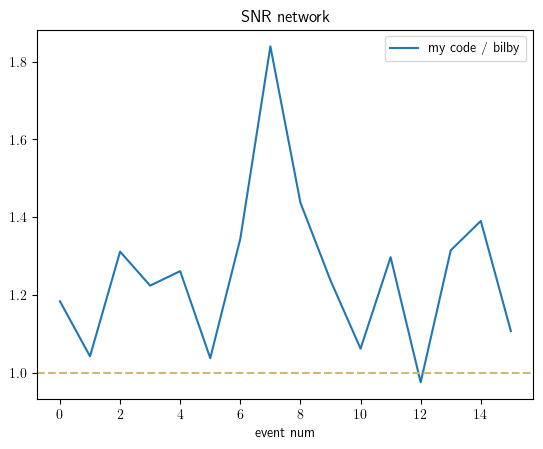

In [297]:
plt.plot(inj_data['selected_n_events']['SNR_network']/bilby_snr['SNR_network'], label='my code / bilby')
#plt.plot(inj_data['selected_n_events']['SNR_network']/gwfish_snr['SNR_network'].values, label='my code / GWFish')
#plt.plot(gwfish_snr['SNR_network'].values/bilby_snr['SNR_network'], label='GWFish / bilby')
#plt.plot(inj_data['selected_n_events']['SNR_network']/pycbc_snrs_from_converted_df['SNR_network'].values, label='my code / PyCBC')
plt.axhline(1, c='y', ls='--')
plt.legend()
plt.xlabel('event num')
plt.title('SNR network')

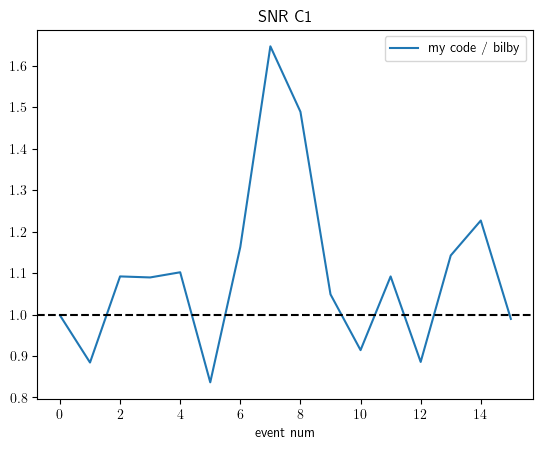

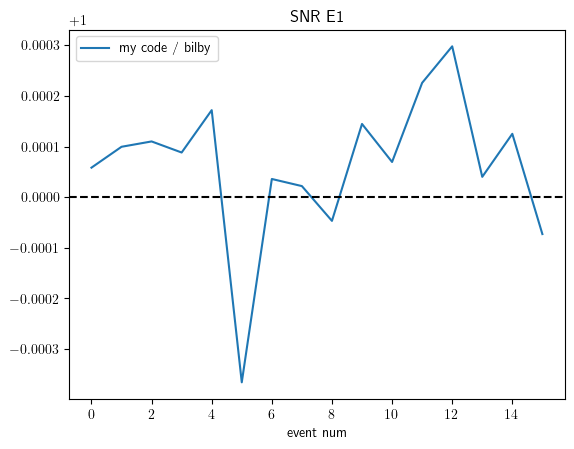

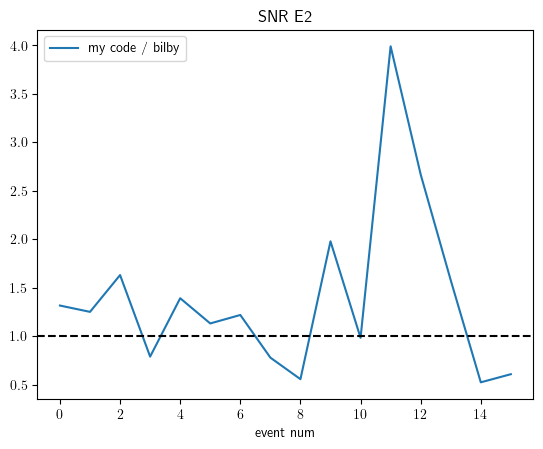

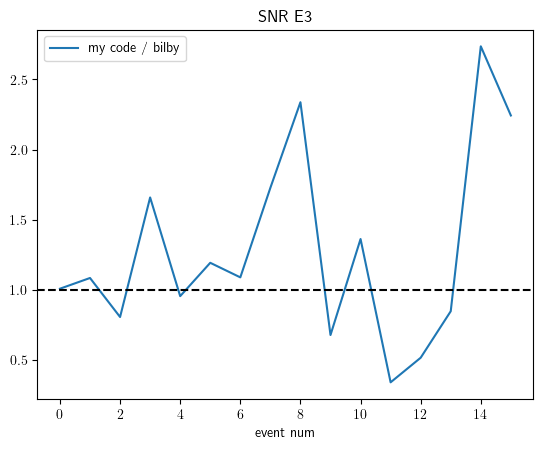

In [300]:
#for det in ['L1', 'H1', 'I1']:
for det in ['C1', 'E1', 'E2', 'E3']:
    plt.figure()
    #plt.plot(pycbc_snrs_from_converted_df[f'SNR_{det}']/bilby_snr[f'SNR_{det}'], label='pycbc / bilby')
    plt.plot(inj_data['selected_n_events'][f'SNR_{det}']/bilby_snr[f'SNR_{det}'].values, label='my code / bilby')
    #plt.plot(gwfish_snr[f'SNR_{det}'].values/bilby_snr[f'SNR_{det}'], label='GWFish / bilby')
    plt.axhline(1, c='k', ls='--')
    plt.legend()
    plt.xlabel('event num')
    plt.title(f'SNR {det}')

## GWBench

In [13]:
from gwbench import Network
pi = np.pi

In [14]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, f_low, f_ref, f_high, df, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':'IMRPhenomXPHM', 'fRef':f_ref}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True},
                 'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/ET10_CoBA-psd.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'},
                 'CE20':{'longitude': -1.6406094969, 'latitude': 0.5061454831, 'arm_azimuth':2*np.pi-5.0614548308, 'which_arm':'y', 
                         'shape':'L'},
                 'I1':{'longitude': 1.34444215058, 'latitude':0.34231676739, 'arm_azimuth':2.0527812170378947, #3.623591506466807, 
                       'which_arm':'x', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    #network_spec = ['A-Sharp_L', 'A-Sharp_H', 'A-Sharp_I1']
    network_spec = ['CE40_C1', 'CE20_CE20', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_snrs()
    return(net)

In [15]:
gwbench_to_pycbc_map = {
    'Mc': 'mchirp',
    'eta': 'eta',
    'DL': 'distance',
    'ra': 'ra',
    'dec': 'dec',
    'psi': 'polarization',
    'chi1z': 'spin1z',
    'chi2z': 'spin2z',
    'tc': 'trigger_time',
    'phic': 'coa_phase'
}

In [16]:
inj_records = inj_data['selected_n_events'].to_records()
gwb_snrs = []
failed_events = {'event_num':[], 'inj_params':[]}
#for event_num in tqdm(range(3)):
for event_num in tqdm(range(len(inj_records))):
    params_i = inj_records[event_num]
    inj_params = {'chi1x': params_i['spin1x'], 
                  'chi1y': params_i['spin1y'],
                  'chi2x': params_i['spin2x'],
                  'chi2y': params_i['spin2y'],
                  'chi1z': params_i['spin1z'],
                  'chi2z': params_i['spin2z']}
    for param in fm_params_str.split():
        if param == 'iota':
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12, a_1, a_2 =  spin_angles(params_i['mass1'], params_i['mass2'], 
                                                                              params_i['inclination'], 
                                                                              params_i['spin1x'], params_i['spin1y'], params_i['spin1z'], 
                                                                              params_i['spin2x'], params_i['spin2y'], params_i['spin2z'], 
                                                                              params_i['f_ref'], params_i['coa_phase'])
            inj_params[param] = theta_jn
        else:
            inj_params[param] = params_i[gwbench_to_pycbc_map[param]]
    net = run_analysis(inj_params, 
                       params_i['f_lower'], 
                       params_i['f_ref'],
                       params_i['f_final'],
                       1/16,
                       num_cores=8)
    snrs = {det.det_key:det.snr for det in net.detectors}
    snrs.update({'SNR_network':net.snr})
    gwb_snrs.append(snrs)
    #except:
    #    failed_events['event_num'].append(event_num)
    #    failed_events['inj_params'].append(inj_params)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.97it/s]


In [17]:
det_map_pycbc_gwb = {'C1':'CE40_C1',
                     'CE20':'CE20_CE20',
                     'E1':'ET10-CoBA_ET1',
                     'E2':'ET10-CoBA_ET2',
                     'E3':'ET10-CoBA_ET3'}

In [18]:
gwb_snrs = pd.DataFrame(gwb_snrs)
gwb_snrs

,CE40_C1,CE20_CE20,ET10-CoBA_ET1,ET10-CoBA_ET2,ET10-CoBA_ET3,SNR_network
0,650.421888,283.840685,348.924016,355.425930,349.793922,934.904014
1,1101.184544,605.515394,294.982246,258.766373,243.200613,1338.796994
2,657.564026,357.972606,372.769748,352.714508,376.779869,982.783147
3,1748.867065,1272.223090,729.261619,644.742331,543.665574,2433.140982
4,692.619005,499.912657,286.747461,336.262909,373.281972,1031.634641
5,820.540353,373.940910,151.386076,176.633863,202.797845,953.080535
6,637.136478,400.189899,208.751110,193.270241,205.123846,830.121106
7,2443.655715,997.197083,1021.703714,1158.912219,1189.048855,3281.257147
8,858.518610,513.026874,130.147730,134.553181,119.877729,1024.531326
9,1385.579680,987.400818,199.227780,366.290736,215.852727,1765.005506


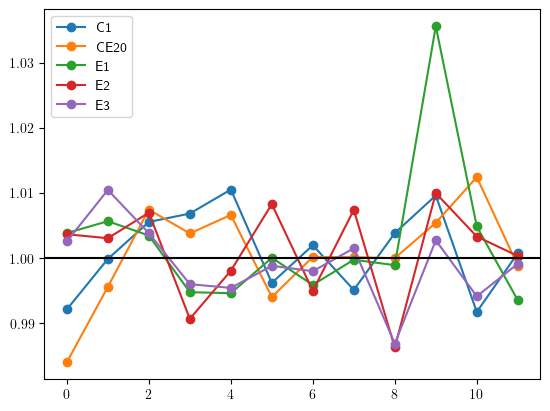

In [19]:
for det in list(det_map_pycbc_gwb.keys()):
    plt.plot(inj_data['selected_n_events'][f'SNR_{det}']/gwb_snrs[det_map_pycbc_gwb[det]], '-o', label=det)
plt.axhline(1, c='k')
plt.legend()

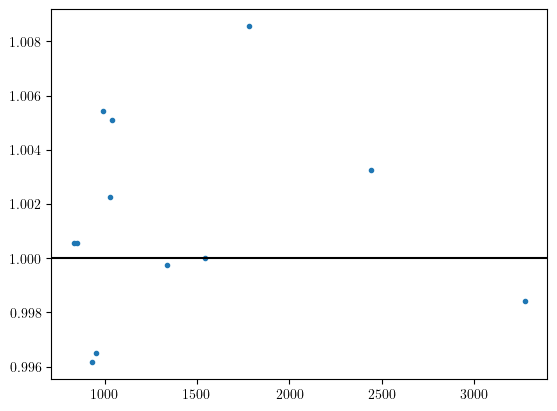

In [20]:
plt.plot(inj_data['selected_n_events']['SNR_network'], inj_data['selected_n_events']['SNR_network']/gwb_snrs['SNR_network'], '.')
plt.axhline(1, c='k')

In [251]:
net.get_detector('CE40_C1').Fp

array([0.16362402])

In [252]:
from pycbc.detector import Detector

In [253]:
d = Detector('C1')

In [263]:
d.antenna_pattern(inj_data['selected_n_events']['ra'][-1:], 
                  inj_data['selected_n_events']['dec'][-1:], 
                  inj_data['selected_n_events']['polarization'][-1:], 
                  inj_data['selected_n_events']['trigger_time'][-1:])

(array([0.15098464]), array([-0.83963992]))

In [250]:
net.get_detector('ET10-CoBA_E1').Fp

array([0.40424335])

In [239]:
from gwbench import detector

In [240]:
detector.Detector?

Init signature: detector.Detector(det_key)
Docstring:     
This class handles calculations for a single gravitational wave detector.

Attributes
----------
det_key : str
    full detector specification, specifying technology and location, e.g. CE2-40-CBO_C
tec : str
    detector technology
loc : str
    detector location
f : np.ndarray
    frequency array
psd : np.ndarray
    detector PSD
Fp : np.ndarray
    plus polarization antenna pattern
Fc : np.ndarray
    cross polarization antenna pattern
Flp : np.ndarray
    location phase factor
hf : np.ndarray
    detector response
del_hf : dict
    derivative dictionary for detector responses
del_hf_expr : dict
    sympy expression of derivative dictionary for detector responses
snr : float
    SNR
snr_sq : float
    SNR^2
d_snr_sq : np.ndarray
    d(SNR^2) calculated from self.hf
fisher : np.ndarray
    Fisher matrix
cond_num : float
    condition number of Fisher matrix
cov : np.ndarray
    covariance matrix
inv_err : dict
    dictionary c

In [42]:
gwb_snrs = []
for sample in tqdm(gwb_inj_params.to_dict(orient='records')):
    net = run_analysis(sample)
    snrs = {det.det_key:det.snr for det in net.detectors}
    snrs.update({'SNR_network':net.snr})
    gwb_snrs.append(snrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.23it/s]


## GWFish

In [ ]:
from GWFish.modules.detection import Network
from GWFish.modules.fishermatrix import compute_network_errors

In [13]:
pycbc_to_pesummary_map = {
    'mchirp': 'chirp_mass',
    'q': 'mass_ratio',
    'distance': 'luminosity_distance',
    'theta_jn': 'theta_jn',
    'ra': 'ra',
    'dec': 'dec',
    'polarization': 'psi',
    'trigger_time': 'geocent_time',
    'coa_phase': 'phase',
    'spin1_a': 'a_1',
    'spin2_a': 'a_2',
    'spin1_polar': 'tilt_1',
    'spin2_polar':'tilt_2',
    'phi_12': 'phi_12',
    'phi_jl': 'phi_jl',
    'mass1': 'mass_1',
    'mass2': 'mass_2'
}
gwfish_det_dict = {'L1':'L', 'H1':'H', 'I1':'IN'}

In [14]:
gwfish_input_data = {pycbc_to_pesummary_map[key]:inj_data['selected_n_events'][key] for key in pycbc_to_pesummary_map.keys() if key != 'q'}
gwfish_input_data = pd.DataFrame(gwfish_input_data)
gwfish_input_data['mass_ratio'] = 1/inj_data['selected_n_events']['q']

In [15]:
gwfish_input_data

,chirp_mass,luminosity_distance,theta_jn,ra,dec,psi,geocent_time,phase,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl,mass_1,mass_2,mass_ratio
0,71.710085,1731.001244,2.502697,5.032525,0.652315,0.358538,1.898516e+09,0.049486,0.625175,0.309239,2.115097,1.911496,0.542926,4.630513,112.098681,61.608261,0.549590
1,28.784349,882.761439,2.193822,0.609846,1.296106,1.987036,1.898884e+09,5.776514,0.506002,0.424179,2.598843,1.085664,0.714457,4.251394,35.579054,30.760254,0.864561
2,26.136114,1142.685938,0.679954,3.325828,-0.387247,0.533400,1.899137e+09,4.314234,0.697060,0.089667,0.653937,1.865643,3.332051,0.873466,33.512777,26.959370,0.804451
3,49.414028,1004.700098,2.308180,2.024654,-0.312625,1.972226,1.899476e+09,6.226073,0.441145,0.302946,1.020867,1.824394,3.824996,5.217051,67.486282,48.017600,0.711516
4,34.863743,1012.222100,0.619327,4.809184,-0.215325,0.917272,1.899598e+09,5.255678,0.212716,0.500878,0.636756,1.909929,2.230564,5.907256,41.132143,38.997820,0.948111
5,6.592950,205.856686,0.609669,2.369114,-0.970579,2.815375,1.900585e+09,0.530393,0.738307,0.585770,2.253311,0.933564,4.663188,4.375148,7.701266,7.447897,0.967100
6,42.235575,1657.971327,0.451065,4.835295,-0.408574,0.419090,1.901824e+09,0.477836,0.425918,0.472543,0.897280,1.124082,3.492746,5.894837,52.618630,44.791124,0.851241
7,19.020100,574.804139,1.382490,2.050192,-0.780764,1.602098,1.905506e+09,3.260259,0.630524,0.971308,1.285583,1.415721,1.836323,0.100216,22.092270,21.607671,0.978065
8,7.737150,119.668025,1.662105,2.464894,-0.104937,0.745376,1.906868e+09,2.932253,0.815941,0.039007,1.453523,1.727256,1.576356,3.245061,10.430791,7.610373,0.729606
9,42.384107,2228.180279,0.342944,3.853865,-0.475035,2.595572,1.908110e+09,0.197642,0.036763,0.543349,1.361044,1.299776,1.946978,2.747124,52.809942,44.943481,0.851042


In [16]:
import GWFish.modules as gwf_mods
import pathlib
#detectors = ['A_sharp_L', 'A_sharp_H', 'A_sharp_IN']
detectors = ['CE1', 'CE2', 'ET']
network = gwf_mods.detection.Network(detector_ids = detectors, detection_SNR = (0., 8.), config=pathlib.Path('detectors.yaml'))
gwfish_snr = gwf_mods.utilities.get_snr(gwfish_input_data, network, 
                                        'IMRPhenomXPHM', 
                                        f_ref=inj_data['selected_n_events']['f_ref'][0])

In [17]:
gwfish_snr.rename(columns={f'A_sharp_{val}':f'SNR_{key}' for key, val in gwfish_det_dict.items()}, inplace=True)
gwfish_snr.rename(columns={'CE1':'SNR_C1', 'CE2':'SNR_CE20', 'ET':'SNR_ET'}, inplace=True)
gwfish_snr.rename(columns={'network':'SNR_network'}, inplace=True)
gwfish_snr

,SNR_C1,SNR_CE20,SNR_ET,SNR_network
event_0,1125.090675,740.680304,417.512297,1410.231491
event_1,741.221444,437.095154,443.626007,968.124701
event_2,724.397655,520.998010,299.837638,941.325394
event_3,1467.229724,781.881299,381.787657,1705.832126
event_4,1261.281898,737.444287,351.070660,1502.633259
event_5,1222.432721,851.178340,853.062264,1716.555141
event_6,673.507502,501.922744,447.949704,951.944186
event_7,910.585130,502.468711,155.204758,1051.536306
event_8,991.264353,589.564304,742.669108,1371.768381
event_9,755.923105,489.282017,211.192192,924.888520


Text(0.5, 1.0, 'my code / GWFish')

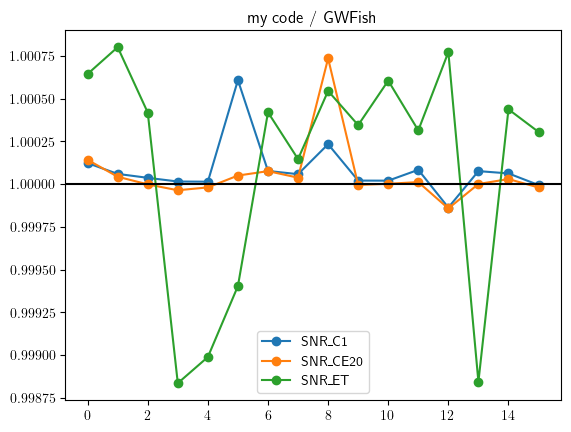

In [18]:
for key in gwfish_snr.keys():
    if 'network' in key:
        continue
    my_snr = inj_data['selected_n_events'][key]
    gwfish_snr_det = gwfish_snr[key].values
    plt.plot(my_snr/gwfish_snr_det, 'o-', label=key)
plt.legend()
plt.axhline(1, c='k')
plt.title('my code / GWFish')